# Triplet loss in TensorFlow 2

Facenet paper: https://www.cv-foundation.org/openaccess/content_cvpr_2015/app/1A_089.pdf

## Install dependencies

In [ ]:
%pip install tensorflow-addons
%pip install -q tensorflow_datasets

## Load dependencies

In [1]:
import io
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

Check you have tensorflow 2 version

In [3]:
tf.__version__

'2.1.0'

## Dataset

For this simple example we will use [MNIST](https://en.wikipedia.org/wiki/MNIST_database).

Loading and splitting the data is managed by TensorFlow Dataset.

In [4]:
train_dataset, test_dataset = tfds.load(name="mnist", split=['train', 'test'], as_supervised=True)

### Preprocessing the Data

We want to normalize the input image between 0 and 1.

In [5]:
def preprocessing_fn(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

### Build the input pipelines

In [6]:
%%time
# Build your input pipelines
train_dataset = train_dataset.shuffle(1024).batch(32)
train_dataset = train_dataset.map(preprocessing_fn)

test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(preprocessing_fn)

CPU times: user 76 ms, sys: 0 ns, total: 76 ms
Wall time: 72.8 ms


Note that the preprocessing function will be applied on demand. We do not have transformed the dataset at this point.

### Display a bach of images and labels

In [7]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(16,8))
    for i in range(32):
        ax = plt.subplot(4, 8, i+1)
        plt.imshow(tf.squeeze(image_batch[i]), cmap='gray_r')
        plt.title(label_batch[i].numpy())
        plt.axis('off')

In [8]:
image_batch, label_batch = next(iter(train_dataset))

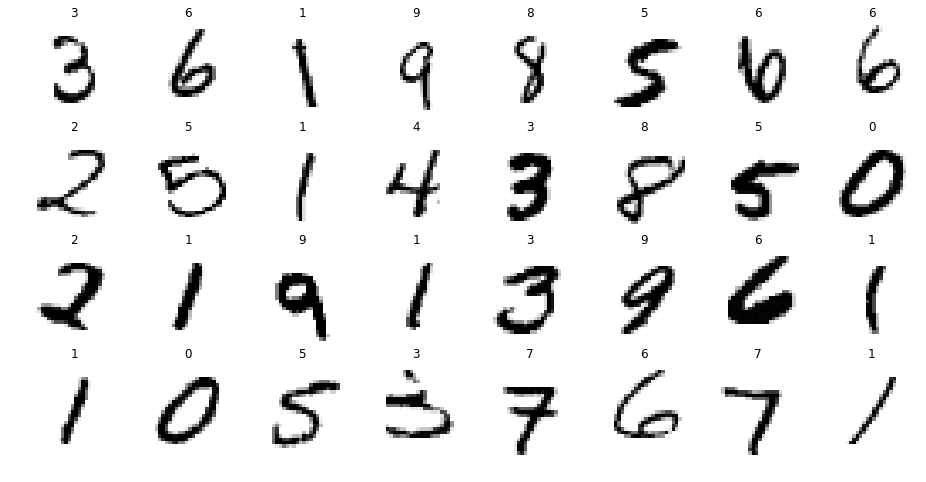

In [9]:
show_batch(image_batch, label_batch)

Alternatively we can also loop over the dataset:

In [10]:
for img, label in test_dataset.take(3):
    print('Img batch shape:', img.shape)
    print('Label batch:', label)

Img batch shape: (32, 28, 28, 1)
Label batch: tf.Tensor([6 2 3 7 2 2 3 4 7 6 6 9 2 0 9 6 8 0 6 5 1 4 8 1 9 8 4 0 0 5 2 4], shape=(32,), dtype=int64)
Img batch shape: (32, 28, 28, 1)
Label batch: tf.Tensor([2 1 3 2 8 1 7 6 8 2 3 3 6 1 0 4 1 0 9 7 7 0 0 5 1 3 5 0 0 7 5 1], shape=(32,), dtype=int64)
Img batch shape: (32, 28, 28, 1)
Label batch: tf.Tensor([3 1 1 0 1 6 1 2 5 0 3 4 4 4 1 3 9 6 3 9 7 5 0 9 6 8 6 9 3 2 4 3], shape=(32,), dtype=int64)


## Model

Let start with a simple convolutional network

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])

#### Resnet like architecture

In [12]:
def res_net_block(input_data, filters, conv_size):
    x = tf.keras.layers.Conv2D(filters, conv_size, activation='relu', padding='same')(input_data)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, conv_size, activation=None, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x, input_data])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [13]:
embedding_size = 16 # Set 3 for a visualization without projection

inputs = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Conv2D(32, 3, activation='relu')(inputs)
x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(3)(x)
num_res_net_blocks = 7
for i in range(num_res_net_blocks):
    x = res_net_block(x, 32, 3)
x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(embedding_size, activation=None)(x)
x = tf.keras.layers.Lambda(lambda y: tf.math.l2_normalize(y, axis=1))(x)
model = tf.keras.Model(inputs, x)

### Compile the model


In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

Look at the implementation here: https://github.com/tensorflow/addons/blob/v0.7.1/tensorflow_addons/losses/triplet.py#L80-L130

In [15]:
#model.summary()

### Train the network

In [16]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=5)

Epoch 1/5
1875/1875 [==============================] - 42s 22ms/step - loss: 0.3206 - val_loss: 0.1562
Epoch 2/5
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0918 - val_loss: 0.0888
Epoch 3/5
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0654 - val_loss: 0.1009
Epoch 4/5
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0540 - val_loss: 0.0496
Epoch 5/5
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0503 - val_loss: 0.0445


Note that the loss here is the triplet loss in the embedding space, not a classification loss.

Question: Why do you think we have a training loss higher than the validation loss ?

### Evaluate the network

In [17]:
embeddings = model.predict(test_dataset) #i.e embeddings

## Save test embeddings for visualization in projector

In [18]:
np.savetxt("vecs_resnet_mnist_16D.tsv", embeddings, delimiter='\t')

out_m = io.open('meta_resnet_mnist_16D.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()

Then load the files on https://projector.tensorflow.org/

## Predict label

At this point we have generated embeddings, but we need a classification algorithm to get the label. <br>
Those algorithm can be slow on big dataset. We will start with a sample.

In [19]:
train_sample_embeddings = []
train_sample_labels = []
for image, label in train_dataset.take(320): #i.e 10240 observations
    train_sample_embeddings.append(model.predict(image))
    train_sample_labels.append(label)
train_sample_embeddings = tf.concat(train_sample_embeddings, axis=0)
train_sample_labels = tf.concat(train_sample_labels, axis=0)

### v1. KNN 

Can be slow for huge dataset.

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
neigh = KNeighborsClassifier(n_neighbors=7) # feel free to cross validate
neigh.fit(X=train_sample_embeddings, y=train_sample_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [22]:
#neigh.predict(embeddings)

In [23]:
%%time
for image, label in test_dataset.take(2):
    embedding = model.predict(image)
    pred = neigh.predict(embedding)
    print(pred)
    print(np.array(label))

[6 2 3 7 2 2 3 4 7 6 6 9 2 0 9 6 8 0 6 5 1 4 8 1 9 8 4 0 0 5 2 4]
[6 2 3 7 2 2 3 4 7 6 6 9 2 0 9 6 8 0 6 5 1 4 8 1 9 8 4 0 0 5 2 4]
[2 1 3 2 8 1 7 6 8 2 3 3 6 1 0 4 1 0 9 7 7 0 0 5 1 3 5 0 0 7 5 1]
[2 1 3 2 8 1 7 6 8 2 3 3 6 1 0 4 1 0 9 7 7 0 0 5 1 3 5 0 0 7 5 1]
CPU times: user 164 ms, sys: 40 ms, total: 204 ms
Wall time: 153 ms


### v2. Custon based on KMedoids
1. Get center of each class
2. Assign new sample to clossest center

Complexity for k class during prediction is independant of the number of training sample n:
- time o(k)
- space o(k)

In [24]:
%pip install scikit-learn-extra

In [25]:
from sklearn_extra.cluster import KMedoids

#### Learn on training sample

In [26]:
kmedoids = KMedoids(n_clusters=10, random_state=2020, init='k-medoids++').fit(train_sample_embeddings)

#### Map class labels to cluster labels

In [27]:
# if we are lucky the metroid is the right label
mapping_cluster_to_class_label = dict()
for i, val in enumerate(kmedoids.medoid_indices_): 
    mapping_cluster_to_class_label[i] = int(train_sample_labels[val])
mapping_cluster_to_class_label

{0: 1, 1: 7, 2: 9, 3: 6, 4: 5, 5: 2, 6: 0, 7: 3, 8: 4, 9: 8}

In [28]:
nb_values = len(set(mapping_cluster_to_class_label.values()))
print(nb_values)
assert nb_values == 10

10


#### Predict function

In [29]:
vect_mapping_cluster_to_class_label = np.vectorize(lambda x: mapping_cluster_to_class_label[x])

def predict_class_from_embedding(embeddings):
    return vect_mapping_cluster_to_class_label(kmedoids.predict(embeddings))

def predict_class_from_images(images):
    embeddings = model.predict(images)
    return vect_mapping_cluster_to_class_label(kmedoids.predict(embeddings))

In [30]:
%%time
for image, label in test_dataset.take(2):
    pred = predict_class_from_images(image)
    print(pred)
    print(np.array(label))

[6 2 3 7 2 2 3 4 7 6 6 9 2 0 9 6 3 0 6 5 1 4 8 1 9 8 4 0 0 5 2 4]
[6 2 3 7 2 2 3 4 7 6 6 9 2 0 9 6 8 0 6 5 1 4 8 1 9 8 4 0 0 5 2 4]
[2 1 3 2 8 1 7 6 8 2 3 3 6 1 0 4 1 0 9 7 7 0 0 5 1 3 5 0 0 7 5 1]
[2 1 3 2 8 1 7 6 8 2 3 3 6 1 0 4 1 0 9 7 7 0 0 5 1 3 5 0 0 7 5 1]
CPU times: user 192 ms, sys: 4 ms, total: 196 ms
Wall time: 139 ms


## Accuracy

In [31]:
%%time
acc = tf.keras.metrics.Accuracy() 
for image, label in test_dataset:
    pred = predict_class_from_images(image)
    _ = acc.update_state(pred, np.array(label)) 
print('Accuracy:', acc.result().numpy())

Accuracy: 0.9864
CPU times: user 15 s, sys: 1.44 s, total: 16.4 s
Wall time: 10.4 s
